In [1]:
import sys, os, time
import logging
import torch
import pickle
import numpy as np
import cv2
from pathlib import Path
import matplotlib.pyplot as plt

sys.path.insert(0, '/home/rajeev-gupta/sensyn_ws/src/GD-MAE')


In [2]:
from pcdet.models.detectors import GraphRCNN
from pcdet.config import cfg, cfg_from_yaml_file
from pcdet.datasets.kitti.kitti_dataset_ns import KittiDataset


In [3]:
log_path = './test_logs.txt'
cfg_file = '/home/rajeev-gupta/sensyn_ws/src/GD-MAE/tools/cfgs/kitti_models/graph_rcnn_voi_ns_kt.yaml'
ckpt_path = '/home/rajeev-gupta/sensyn_ws/src/GD-MAE/data/ckpts/graph_rcnn_voi_kitti.pth'
to_cpu = False
batch_size = 1
dist_test = False
workers = 4
root_path = Path('/media/rajeev-gupta/Drive250/SENSYN_/CMT')

In [4]:
#Logger
def create_logger(log_file=None, rank=0, log_level=logging.INFO):
    logger = logging.getLogger(__name__)
    logger.setLevel(log_level if rank == 0 else 'ERROR')
    formatter = logging.Formatter('%(asctime)s  %(levelname)5s  %(message)s')
    console = logging.StreamHandler()
    console.setLevel(log_level if rank == 0 else 'ERROR')
    console.setFormatter(formatter)
    logger.addHandler(console)
    if log_file is not None:
        file_handler = logging.FileHandler(filename=log_file)
        file_handler.setLevel(log_level if rank == 0 else 'ERROR')
        file_handler.setFormatter(formatter)
        logger.addHandler(file_handler)
    logger.propagate = False
    return logger

In [5]:
def load_data_to_gpu(batch_dict):
    for key, val in batch_dict.items():
        if not isinstance(val, np.ndarray):
            continue
        elif key in ['frame_id', 'metadata', 'calib', 'image_shape', 'image_pad_shape', 'image_rescale_shape', 'image_path']:
            continue
        else:
            batch_dict[key] = torch.from_numpy(val).float().cuda()


In [6]:
from torch.utils.data import DataLoader

def build_dataloader(dataset, batch_size, workers=4,
                     training=False, drop_last=False):
    sampler = None
    dataloader = DataLoader(
        dataset, batch_size=batch_size, pin_memory=True, num_workers=workers,
        shuffle=(sampler is None) and training, collate_fn=dataset.collate_batch,
        drop_last=drop_last, sampler=sampler, timeout=0
    )

    return dataloader


In [7]:
logger = create_logger(log_path)

In [8]:
cfg_from_yaml_file(cfg_file, cfg)

{'ROOT_DIR': PosixPath('/home/rajeev-gupta/sensyn_ws/src/GD-MAE'),
 'LOCAL_RANK': 0,
 'CLASS_NAMES': ['Car'],
 'DATA_CONFIG': {'DATASET': 'KittiDataset',
  'DATA_PATH': '../data/kitti',
  'BACKEND': {'NAME': 'HardDiskBackend'},
  'POINT_CLOUD_RANGE': [-102.4, 0, -6.0, 102.4, 204.8, 10.0],
  'DATA_SPLIT': {'train': 'train', 'test': 'val'},
  'INFO_PATH': {'train': ['nuscenes_infos_train.pkl'],
   'test': ['nuscenes_infos_val.pkl']},
  'GET_ITEM_LIST': ['points', 'image', 'calib_matricies', 'gt_boxes2d'],
  'FOV_POINTS_ONLY': False,
  'ENABLE_SIMILAR_TYPE': True,
  'DATA_AUGMENTOR': {'DISABLE_AUG_LIST': ['placeholder'],
   'AUG_CONFIG_LIST': [{'NAME': 'random_world_flip',
     'PROBABILITY': 0.5,
     'ALONG_AXIS_LIST': ['x']},
    {'NAME': 'random_world_rotation',
     'PROBABILITY': 1.0,
     'WORLD_ROT_ANGLE': [-0.78539816, 0.78539816]},
    {'NAME': 'random_world_scaling',
     'PROBABILITY': 1.0,
     'WORLD_SCALE_RANGE': [0.95, 1.05]}]},
  'POINT_FEATURE_ENCODING': {'encoding_type'

In [9]:
dataset = KittiDataset(
        dataset_cfg=cfg.DATA_CONFIG,
        class_names=cfg.CLASS_NAMES,
        root_path=root_path,
        training=False,
        logger=logger,
    )

2024-07-18 16:00:20,581   INFO  Loading NuScenes dataset
2024-07-18 16:00:20,597   INFO  Total samples for NuScenes dataset: 81


In [10]:
dataset.kitti_infos

[{'lidar_path': '/media/rajeev-gupta/Drive250/SENSYN_/CMT/data/nuscenes/samples/LIDAR_TOP/n008-2018-08-01-15-16-36-0400__LIDAR_TOP__1533151603547590.pcd.bin',
  'token': '3e8750f331d7499e9b5123e9eb70f2e2',
  'sweeps': [],
  'cams': {'CAM_FRONT': {'data_path': 'data/nuscenes/samples/CAM_FRONT/n008-2018-08-01-15-16-36-0400__CAM_FRONT__1533151603512404.jpg',
    'type': 'CAM_FRONT',
    'sample_data_token': '4f5e35aa6c6a426ca945e206fb2f4921',
    'sensor2ego_translation': [1.72200568478, 0.00475453292289, 1.49491291905],
    'sensor2ego_rotation': [0.5077241387638071,
     -0.4973392230703816,
     0.49837167536166627,
     -0.4964832014373754],
    'ego2global_translation': [599.849775495386, 1647.6411294309523, 0.0],
    'ego2global_rotation': [-0.9687876119182126,
     -0.004506968075376869,
     -0.00792272203393983,
     0.24772460658591755],
    'timestamp': 1533151603512404,
    'sensor2lidar_rotation': array([[ 0.99988013, -0.01013819, -0.0117025 ],
           [ 0.01223258,  0.053

In [11]:
test_loader = build_dataloader(
        dataset, batch_size=batch_size, workers=workers, training=False
    )

In [12]:
len(test_loader)

81

In [13]:
# for i, batch in enumerate(test_loader):
#     print(batch)
#     break


In [14]:
get_dict = dataset.__getitem__(4)
get_dict

{'frame_id': 'n008-2018-08-01-15-16-36-0400__LIDAR_TOP__1533151605548192.pcd',
 'calib': <pcdet.utils.calibration_nuscene.Calibration at 0x7f279045add0>,
 'points': array([[-64.80741   ,   0.16542324,  -3.128293  ,  36.        ],
        [-66.23342   ,   0.1971528 ,  -1.6452059 ,  39.        ],
        [-55.095726  ,   0.1158025 ,   1.183809  ,  21.        ],
        ...,
        [-54.534595  ,   0.12376494,   2.5431786 ,  23.        ],
        [-54.88781   ,   0.14375134,   3.8381455 ,  24.        ],
        [-60.0729    ,   0.17823443,   5.6045413 ,  28.        ]],
       dtype=float32),
 'metadata': {'token': '747aa46b9a4641fe90db05d97db2acea'},
 'image': array([[[-0.16331805, -0.28674215, -0.22454627],
         [-0.19049086, -0.31535813, -0.25274906],
         [-0.21763329, -0.34394214, -0.2809203 ],
         ...,
         [-0.6794497 , -0.8589022 , -1.0140667 ],
         [-0.67948   , -0.8589341 , -1.014098  ],
         [-0.6930361 , -0.8732102 , -1.0281681 ]],
 
        [[-0.2040

In [15]:
img = get_dict['image']
img.shape

(896, 1600, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


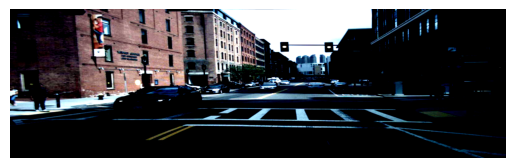

In [16]:
plt.imshow(cv2.cvtColor(cv2.resize(img, (1280, 384), interpolation=cv2.INTER_LINEAR), cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [17]:
h, w = img.shape[:2]
h0, w0 = 384, 1280
img = img[(h-h0)//2:928-(h-h0)//2, (w-w0)//2:1600-(w-w0)//2, :]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


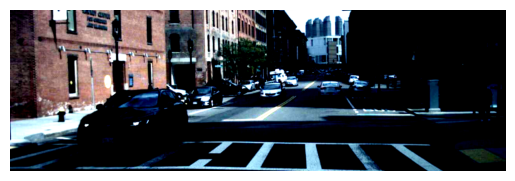

In [18]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.axis('off')
plt.show()

In [19]:
img.shape

(416, 1280, 3)

In [20]:
# get_dict['image'] = img
# get_dict['image_pad_shape'] = img.shape[:2]
# get_dict['image_rescale_shape'] = img.shape[:2]

In [21]:
get_dict['points'].shape

(14201, 4)

In [22]:
get_dict['points'][852]

array([-3.766602  ,  0.47743028, -1.8655529 ,  4.        ], dtype=float32)

In [23]:
for key, val in get_dict.items():
    print(key)
    if type(val) == tuple:
        get_dict[key] = list(val)
    elif key == 'points':
        # add a zero column
        n = val.shape[0]
        z_col = np.zeros((n, 1), dtype=float)
        get_dict[key] = np.concatenate((z_col, val), axis = 1)
        get_dict[key][:, 4] /= 255
        continue
    elif key == 'image':
        # transpose (384, 1280, 3) to (3, 384, 1280)
        val_transposed = np.transpose(val, (2, 0, 1))
        get_dict[key] = val_transposed
        # print(get_dict[key].shape)
    elif key == 'transformation_2d_list' or key == 'transformation_2d_params':
        get_dict[key] = [val]
        continue
    get_dict[key] = np.array([get_dict[key]])
            
get_dict['batch_size'] = 1
# get_dict['points'][:, 4] = 1
# get_dict['points'][:, 4] /= 255

frame_id
calib
points
metadata
image
image_path
trans_lidar_to_cam
trans_cam_to_img
gt_boxes
use_lead_xyz
transformation_2d_list
transformation_2d_params
image_rescale_shape
image_pad_shape
image_shape


In [24]:
get_dict

{'frame_id': array(['n008-2018-08-01-15-16-36-0400__LIDAR_TOP__1533151605548192.pcd'],
       dtype='<U62'),
 'calib': array([<pcdet.utils.calibration_nuscene.Calibration object at 0x7f279045add0>],
       dtype=object),
 'points': array([[  0.        , -64.80741119,   0.16542324,  -3.12829304,
           0.14117647],
        [  0.        , -66.23342133,   0.19715279,  -1.64520586,
           0.15294118],
        [  0.        , -55.09572601,   0.1158025 ,   1.18380904,
           0.08235294],
        ...,
        [  0.        , -54.53459549,   0.12376494,   2.54317856,
           0.09019608],
        [  0.        , -54.88780975,   0.14375134,   3.83814549,
           0.09411765],
        [  0.        , -60.07289886,   0.17823443,   5.6045413 ,
           0.10980392]]),
 'metadata': array([{'token': '747aa46b9a4641fe90db05d97db2acea'}], dtype=object),
 'image': array([[[[-0.16331805, -0.19049086, -0.21763329, ..., -0.6794497 ,
           -0.67948   , -0.6930361 ],
          [-0.20407726

In [25]:
get_dict['image'].shape

(1, 3, 896, 1600)

In [26]:
get_dict['points'].shape

(14201, 5)

In [27]:
from pcdet.utils.calibration_nuscene import encircle_pixel_in_image, point_cloud_to_image, image_to_point_cloud

complexity of algorithm  8048


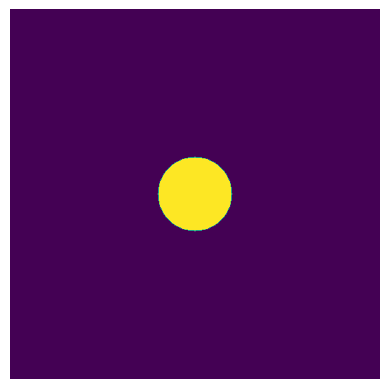

In [28]:
# test
image_arr = np.zeros((501, 501))
image_arr, _ = encircle_pixel_in_image(image_arr, [250, 250], 255, 50, print_complexity=True)
# print(image_arr)
plt.imshow(image_arr)
plt.axis('off')  # Optional: turn off axis
plt.show()

(14201, 2) -21526348.050703738 41983991.96015796 -3266067.7062808834 14302536.529460868


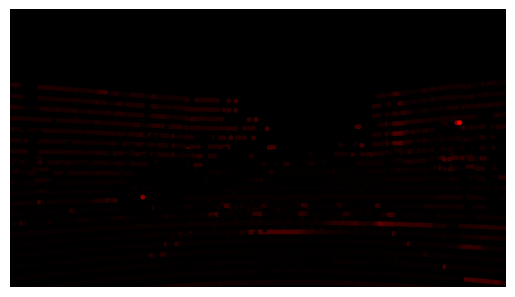

In [29]:
image_arr = point_cloud_to_image(get_dict, point_radii = 8)

In [30]:
# new_points = image_to_point_cloud(get_dict, extrapolation_radii=2)
# new_points

In [31]:
# new_points.dtype

In [32]:
# new_points.astype(np.float32).tofile('./new_points_ns.bin')

In [33]:
# new_points = np.concatenate((np.zeros((new_points.shape[0], 1)), new_points, np.ones((new_points.shape[0], 1))), axis=1)

In [34]:
# new_points.shape

In [35]:
# new_points[0]

In [36]:
# get_dict['points'] = new_points

In [37]:
img = get_dict['image']
img.shape

(1, 3, 896, 1600)

In [38]:
# img = img.cpu().numpy()
# img.shape

In [39]:
get_dict['points'].shape

(14201, 5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


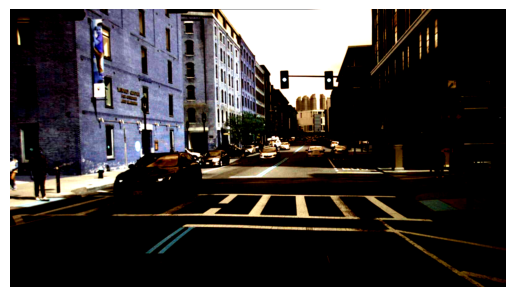

In [40]:
import matplotlib.pyplot as plt

# img = cv2.cvtColor(np.transpose(img[0], (1, 2, 0)), cv2.COLOR_BGR2RGB)
img = np.transpose(img[0], (1, 2, 0))
plt.imshow(img)
plt.axis('off')  # Hide the axis
plt.show()

In [41]:
get_dict['image'].shape

(1, 3, 896, 1600)

In [42]:
model = GraphRCNN(cfg.MODEL, num_class=len(cfg.CLASS_NAMES), dataset=dataset, logger=logger)

In [ ]:
with torch.no_grad():
    model.load_params_from_file(filename=ckpt_path, logger=logger, to_cpu=to_cpu)
    model.cuda()
    model.eval()
    time.sleep(2)

2024-07-16 12:25:25,092   INFO  ==> Loading parameters from checkpoint /home/rajeev-gupta/sensyn_ws/src/GD-MAE/data/ckpts/graph_rcnn_voi_kitti.pth to GPU
2024-07-16 12:25:25,785   INFO  ==> Done (loaded 518/518)


In [ ]:
data_input = get_dict
# data_input = b_dict
torch.cuda.synchronize()
start_time = time.time()
load_data_to_gpu(data_input)
pred_dicts, ret_dict = model(data_input)
torch.cuda.synchronize()
end_time = time.time()
print('Inference Time: ', end_time-start_time)

pred_dicts

Inference Time:  0.8619484901428223


[{'pred_boxes': tensor([], device='cuda:0', size=(0, 7), grad_fn=<IndexBackward0>),
  'pred_scores': tensor([], device='cuda:0', grad_fn=<IndexBackward0>),
  'pred_labels': tensor([], device='cuda:0', dtype=torch.int64)}]

In [ ]:
# log_path = './test_logs.txt'
# cfg_file = '/home/rajeev-gupta/sensyn_ws/src/GD-MAE/tools/cfgs/kitti_models/graph_rcnn_voi.yaml'
# ckpt_path = '/home/rajeev-gupta/sensyn_ws/src/GD-MAE/data/ckpts/graph_rcnn_voi_kitti.pth'
# to_cpu = False

# def load_data_to_gpu(batch_dict):
#     for key, val in batch_dict.items():
#         if not isinstance(val, np.ndarray):
#             continue
#         elif key in ['frame_id', 'metadata', 'calib', 'image_shape', 'image_pad_shape', 'image_rescale_shape']:
#             continue
#         else:
#             batch_dict[key] = torch.from_numpy(val).float().cuda()

# from pcdet.config import cfg as cfg2
# cfg_from_yaml_file(cfg_file, cfg2)


# def get_calib_from_file(calib_file):
#     lines = open(calib_file).readlines()

#     obj = lines[2].strip().split(' ')[1:]
#     P2 = np.array(obj, dtype=np.float32)
#     obj = lines[3].strip().split(' ')[1:]
#     P3 = np.array(obj, dtype=np.float32)
#     obj = lines[4].strip().split(' ')[1:]
#     R0 = np.array(obj, dtype=np.float32)
#     obj = lines[5].strip().split(' ')[1:]
#     Tr_velo_to_cam = np.array(obj, dtype=np.float32)

#     return {'P2': P2.reshape(3, 4),
#             'P3': P3.reshape(3, 4),
#             'R0': R0.reshape(3, 3),
#             'Tr_velo2cam': Tr_velo_to_cam.reshape(3, 4)}

# def calib_to_matricies(calib):
#     """
#     Converts calibration object to transformation matricies
#     Args:
#         calib: calibration.Calibration, Calibration object
#     Returns
#         V2R: (4, 4), Lidar to rectified camera transformation matrix
#         P2: (3, 4), Camera projection matrix
#     """
#     V2C = np.vstack((calib.V2C, np.array([0, 0, 0, 1], dtype=np.float32)))  # (4, 4)
#     R0 = np.hstack((calib.R0, np.zeros((3, 1), dtype=np.float32)))  # (3, 4)
#     R0 = np.vstack((R0, np.array([0, 0, 0, 1], dtype=np.float32)))  # (4, 4)
#     V2R = R0 @ V2C
#     P2 = calib.P2
#     return V2R, P2



# class Calibration(object):
#     def __init__(self, calib_file):
#         if not isinstance(calib_file, dict):
#             calib = get_calib_from_file(calib_file)
#         else:
#             calib = calib_file

#         self.P2 = calib['P2']  # 3 x 4
#         self.R0 = calib['R0']  # 3 x 3
#         self.V2C = calib['Tr_velo2cam']  # 3 x 4

#         # Camera intrinsics and extrinsics
#         self.cu = self.P2[0, 2]
#         self.cv = self.P2[1, 2]
#         self.fu = self.P2[0, 0]
#         self.fv = self.P2[1, 1]
#         self.tx = self.P2[0, 3] / (-self.fu)
#         self.ty = self.P2[1, 3] / (-self.fv)

#     def cart_to_hom(self, pts):
#         """
#         :param pts: (N, 3 or 2)
#         :return pts_hom: (N, 4 or 3)
#         """
#         pts_hom = np.hstack((pts, np.ones((pts.shape[0], 1), dtype=np.float32)))
#         return pts_hom

#     def rect_to_lidar(self, pts_rect):
#         """
#         :param pts_lidar: (N, 3)
#         :return pts_rect: (N, 3)
#         """
#         pts_rect_hom = self.cart_to_hom(pts_rect)  # (N, 4)
#         R0_ext = np.hstack((self.R0, np.zeros((3, 1), dtype=np.float32)))  # (3, 4)
#         R0_ext = np.vstack((R0_ext, np.zeros((1, 4), dtype=np.float32)))  # (4, 4)
#         R0_ext[3, 3] = 1
#         V2C_ext = np.vstack((self.V2C, np.zeros((1, 4), dtype=np.float32)))  # (4, 4)
#         V2C_ext[3, 3] = 1

#         pts_lidar = np.dot(pts_rect_hom, np.linalg.inv(np.dot(R0_ext, V2C_ext).T))
#         return pts_lidar[:, 0:3]

#     def lidar_to_rect(self, pts_lidar):
#         """
#         :param pts_lidar: (N, 3)
#         :return pts_rect: (N, 3)
#         """
#         pts_lidar_hom = self.cart_to_hom(pts_lidar)
#         pts_rect = np.dot(pts_lidar_hom, np.dot(self.V2C.T, self.R0.T))
#         # pts_rect = reduce(np.dot, (pts_lidar_hom, self.V2C.T, self.R0.T))
#         return pts_rect

#     def rect_to_img(self, pts_rect):
#         """
#         :param pts_rect: (N, 3)
#         :return pts_img: (N, 2)
#         """
#         pts_rect_hom = self.cart_to_hom(pts_rect)
#         pts_2d_hom = np.dot(pts_rect_hom, self.P2.T)
#         pts_img = (pts_2d_hom[:, 0:2].T / pts_rect_hom[:, 2]).T  # (N, 2)
#         pts_rect_depth = pts_2d_hom[:, 2] - self.P2.T[3, 2]  # depth in rect camera coord
#         return pts_img, pts_rect_depth

#     def lidar_to_img(self, pts_lidar):
#         """
#         :param pts_lidar: (N, 3)
#         :return pts_img: (N, 2)
#         """
#         pts_rect = self.lidar_to_rect(pts_lidar)
#         pts_img, pts_depth = self.rect_to_img(pts_rect)
#         return pts_img, pts_depth

#     def img_to_rect(self, u, v, depth_rect):
#         """
#         :param u: (N)
#         :param v: (N)
#         :param depth_rect: (N)
#         :return:
#         """
#         x = ((u - self.cu) * depth_rect) / self.fu + self.tx
#         y = ((v - self.cv) * depth_rect) / self.fv + self.ty
#         pts_rect = np.concatenate((x.reshape(-1, 1), y.reshape(-1, 1), depth_rect.reshape(-1, 1)), axis=1)
#         return pts_rect

#     def corners3d_to_img_boxes(self, corners3d):
#         """
#         :param corners3d: (N, 8, 3) corners in rect coordinate
#         :return: boxes: (None, 4) [x1, y1, x2, y2] in rgb coordinate
#         :return: boxes_corner: (None, 8) [xi, yi] in rgb coordinate
#         """
#         sample_num = corners3d.shape[0]
#         corners3d_hom = np.concatenate((corners3d, np.ones((sample_num, 8, 1))), axis=2)  # (N, 8, 4)

#         img_pts = np.matmul(corners3d_hom, self.P2.T)  # (N, 8, 3)

#         x, y = img_pts[:, :, 0] / img_pts[:, :, 2], img_pts[:, :, 1] / img_pts[:, :, 2]
#         x1, y1 = np.min(x, axis=1), np.min(y, axis=1)
#         x2, y2 = np.max(x, axis=1), np.max(y, axis=1)

#         boxes = np.concatenate((x1.reshape(-1, 1), y1.reshape(-1, 1), x2.reshape(-1, 1), y2.reshape(-1, 1)), axis=1)
#         boxes_corner = np.concatenate((x.reshape(-1, 8, 1), y.reshape(-1, 8, 1)), axis=2)

#         return boxes, boxes_corner



# from pathlib import Path

# import numpy as np
# import torch.utils.data as torch_data

# # from ..utils import common_utils, file_client
# # from ..pcdet.datasets.augmentor.data_augmentor import DataAugmentor
# from pcdet.datasets.processor.data_processor import DataProcessor
# from pcdet.datasets.processor.point_feature_encoder import PointFeatureEncoder

# class CustomKittiDataset(torch_data.Dataset):
#     def __init__(self, dataset_cfg=None, class_names=None, training=True, root_path=None, logger=None):
#         super().__init__()
#         self.dataset_cfg = dataset_cfg
#         self.training = training
#         self.class_names = class_names
#         self.logger = logger
#         self.root_path = Path(root_path) if root_path is not None else Path(self.dataset_cfg.DATA_PATH)

#         self.point_cloud_range = np.array(self.dataset_cfg.POINT_CLOUD_RANGE, dtype=np.float32)
#         self.point_feature_encoder = PointFeatureEncoder(
#             self.dataset_cfg.POINT_FEATURE_ENCODING,
#             point_cloud_range=self.point_cloud_range
#         )
#         self.data_processor = DataProcessor(
#             self.dataset_cfg.DATA_PROCESSOR, point_cloud_range=self.point_cloud_range,
#             training=self.training, num_point_features=self.point_feature_encoder.num_point_features
#         )
#         self.grid_size = self.data_processor.grid_size
#         self.voxel_size = self.data_processor.voxel_size
#         self.total_epochs = 0
#         self.cur_epoch = 0
#         self._merge_all_iters_to_one_epoch = False

#     @property
#     def mode(self):
#         return 'train' if self.training else 'test'
        
#     def __getitem__(self, index):
#         info_path = '/media/rajeev-gupta/Drive250/SENSYN_/data/kitti/kitti_infos_test.pkl'
#         with open(info_path, 'rb') as i_file:
#             i_dict = pickle.load(i_file)
#         info = i_dict[index]
        
#         sample_idx = info['point_cloud']['lidar_idx']
#         img_shape = info['image']['image_shape']
#         calib = self.get_calib(sample_idx)
#         get_item_list = self.dataset_cfg.get('GET_ITEM_LIST', ['points'])

#         input_dict = {
#             'frame_id': sample_idx,
#             'calib': calib,
#         }

#         if "points" in get_item_list:
#             points = self.get_lidar(sample_idx)
#             if self.dataset_cfg.FOV_POINTS_ONLY:
#                 pts_rect = calib.lidar_to_rect(points[:, 0:3])
#                 fov_flag = self.get_fov_flag(pts_rect, img_shape, calib)
#                 points = points[fov_flag]
#             input_dict['points'] = points

#         if "image" in get_item_list:
#             input_dict['image'] = self.get_image(sample_idx)

#         if "calib_matricies" in get_item_list:
#             input_dict["trans_lidar_to_cam"], input_dict["trans_cam_to_img"] = calib_to_matricies(calib)

#         data_dict = self.prepare_data(data_dict=input_dict)

#         data_dict['image_shape'] = img_shape
#         return data_dict
    
#     def get_calib(self, idx):
#         calib_file = self.root_path / 'testing' / 'calib' / ('%s.txt' % idx)
#         return Calibration(calib_file)

#     def get_lidar(self, idx):
#         lidar_file = self.root_path / 'testing' / 'velodyne' / ('%s.bin' % idx)
#         return np.fromfile(lidar_file, dtype=np.float32).reshape(-1, 4)
    
#     def get_image(self, idx):
#         img_file = self.root_path / 'testing' / 'image_2' / ('%s.png' % idx)
#         return cv2.imread(str(img_file), cv2.IMREAD_COLOR)
    
#     def prepare_data(self, data_dict):
#         if data_dict.get('points', None) is not None:
#             data_dict = self.point_feature_encoder.forward(data_dict)

#         data_dict = self.data_processor.forward(
#             data_dict=data_dict
#         )
#         return data_dict

#     @staticmethod
#     def get_fov_flag(pts_rect, img_shape, calib):
#         print('def get_fov_flag ******************')
#         """
#         Args:
#             pts_rect:
#             img_shape:
#             calib:

#         Returns:

#         """
#         pts_img, pts_rect_depth = calib.rect_to_img(pts_rect)
#         val_flag_1 = np.logical_and(pts_img[:, 0] >= 0, pts_img[:, 0] < img_shape[1])
#         val_flag_2 = np.logical_and(pts_img[:, 1] >= 0, pts_img[:, 1] < img_shape[0])
#         val_flag_merge = np.logical_and(val_flag_1, val_flag_2)
#         pts_valid_flag = np.logical_and(val_flag_merge, pts_rect_depth >= 0)

#         return pts_valid_flag



# dataset = CustomKittiDataset(
#         dataset_cfg=cfg2.DATA_CONFIG,
#         class_names=cfg2.CLASS_NAMES,
#         root_path='/home/rajeev-gupta/sensyn_ws/src/GD-MAE/data/kitti',
#         training=False,
#         logger=logger,
#     )


# get_dict = dataset.__getitem__(45)



# for key, val in get_dict.items():
#     print(key)
#     if type(val) == tuple:
#         get_dict[key] = list(val)
#     elif key == 'points':
#         # add a zero column
#         n = val.shape[0]
#         z_col = np.zeros((n, 1), dtype=float)
#         get_dict[key] = np.concatenate((z_col, val), axis = 1)
#         continue
#     elif key == 'image':
#         # transpose (384, 1280, 3) to (3, 384, 1280)
#         val_transposed = np.transpose(val, (2, 0, 1))
#         get_dict[key] = val_transposed
#         # print(get_dict[key].shape)
#     elif key == 'transformation_2d_list' or key == 'transformation_2d_params':
#         get_dict[key] = [val]
#         continue
#     get_dict[key] = np.array([get_dict[key]])
            
# get_dict['batch_size'] = 1

# get_dict